Ce travail met en place une r√©gression logistique bay√©sienne compl√®te pour d√©tecter les d√©fauts sur les syst√®mes HVAC √† partir de donn√©es capteurs. Bien que la cha√Æne d‚Äôapprentissage et d‚Äô√©valuation soit correcte et la probabilit√© pr√©dite avec incertitude soit accessible, les r√©sultats sont faibles en termes de rappel et F1-score. Cela s‚Äôexplique par la simplicit√© du mod√®le et la faible diversit√© de donn√©es d‚Äôentra√Ænement. Ce premier mod√®le valide le cadre probabiliste mais doit √™tre enrichi avec des architectures plus puissantes et des donn√©es plus vari√©es pour devenir un d√©tecteur fiable g√©n√©ralisable.

In [76]:
import pandas as pd

# 1.1 Chargement du fichier
file_path = r"C:\Users\ADMIN\Desktop\Data Sets for AFDD Evauluation of Building FDD Algorithms\MZVAV-1.csv"
df = pd.read_csv(file_path)

# 1.2 Conversion de la colonne de temps
df['Datetime'] = pd.to_datetime(df['Datetime'])

# 1.3 Filtrage sur les deux jours : 5 et 6 f√©vrier 2017
start_date = pd.to_datetime("2017-02-04")
end_date = pd.to_datetime("2017-02-07 23:59:59")
df_filtered = df[(df['Datetime'] >= start_date) & (df['Datetime'] <= end_date)].copy()

# R√©initialisation de l'index (optionnelle mais pratique)
df_filtered.reset_index(drop=True, inplace=True)

# Aper√ßu du r√©sultat
print(df_filtered['Datetime'].min(), "‚Üí", df_filtered['Datetime'].max())
print("Nombre de lignes :", len(df_filtered))
df_filtered.head()


2017-02-04 00:00:00 ‚Üí 2017-02-07 23:59:00
Nombre de lignes : 5760


Datetime  AHU: Supply Air Temperature  \
0 2017-02-04 00:00:00                        51.96   
1 2017-02-04 00:01:00                        51.96   
2 2017-02-04 00:02:00                        51.96   
3 2017-02-04 00:03:00                        51.96   
4 2017-02-04 00:04:00                        51.96   

   AHU: Supply Air Temperature Set Point  AHU: Outdoor Air Temperature  \
0                                  55.04                         39.92   
1                                  55.04                         39.92   
2                                  55.04                         39.90   
3                                  55.04                         39.89   
4                                  55.04                         39.87   

   AHU: Mixed Air Temperature  AHU: Return Air Temperature  \
0                       60.66                        67.14   
1                       60.66                        67.13   
2                       60.66                        67.11   
3                       60.66                        67.09   
4                       60.66                        67.07   

   AHU: Supply Air Fan Status  AHU: Return Air Fan Status  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   AHU: Supply Air Fan Speed Control Signal  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   

   AHU: Return Air Fan Speed Control Signal  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   

   AHU: Outdoor Air Damper Control Signal    \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   

   AHU: Return Air Damper Control Signal  \
0                                    0.0   
1                                    0.0   
2                                    0.0   
3                                    0.0   
4                                    0.0   

   AHU: Cooling Coil Valve Control Signal  \
0                                     0.0   
1                                     0.0   
2                                     0.0   
3                                     0.0   
4                                     0.0   

   AHU: Heating Coil Valve Control Signal  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   

   AHU: Supply Air Duct Static Pressure Set Point  \
0                                            0.04   
1                                            0.04   
2                                            0.04   
3                                            0.04   
4                                            0.04   

   AHU: Supply Air Duct Static Pressure  Occupancy Mode Indicator  \
0                                   0.0                         0   
1                                   0.0                         0   
2                                   0.0                         0   
3                                   0.0                         0   
4                                   0.0                         0   

   Fault Detection Ground Truth  
0                             0  
1                             0  
2          

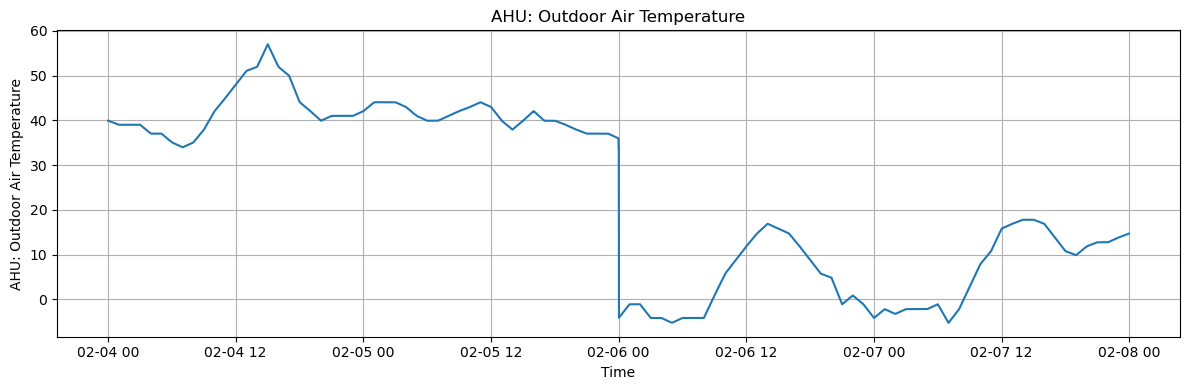

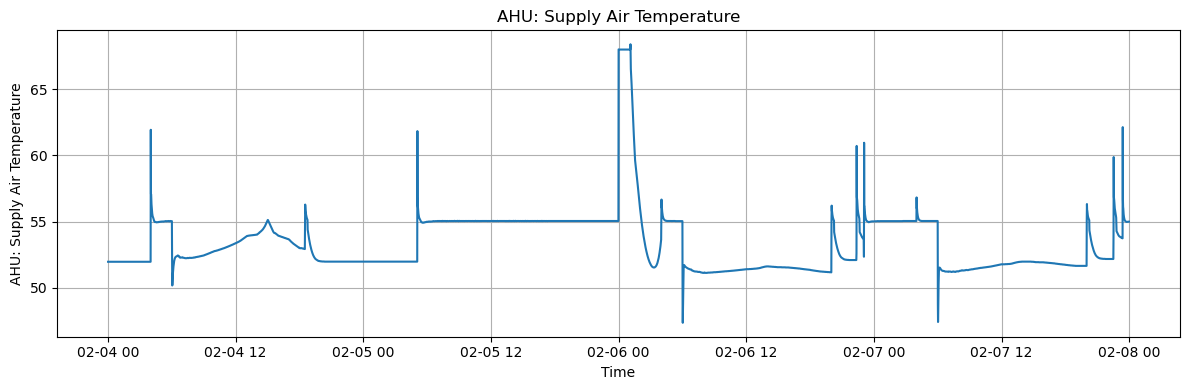

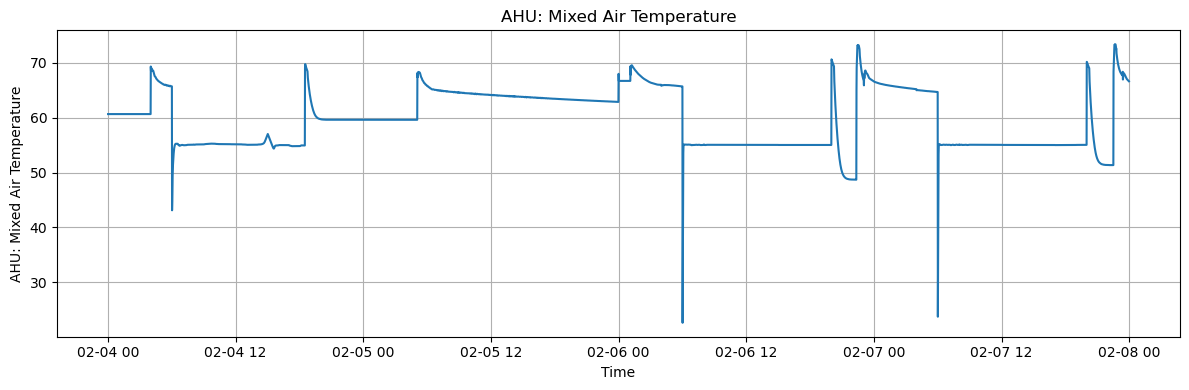

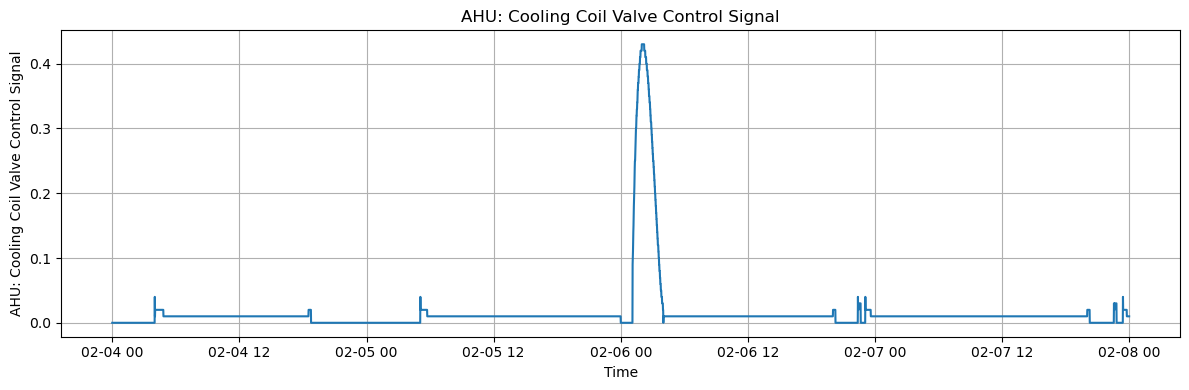

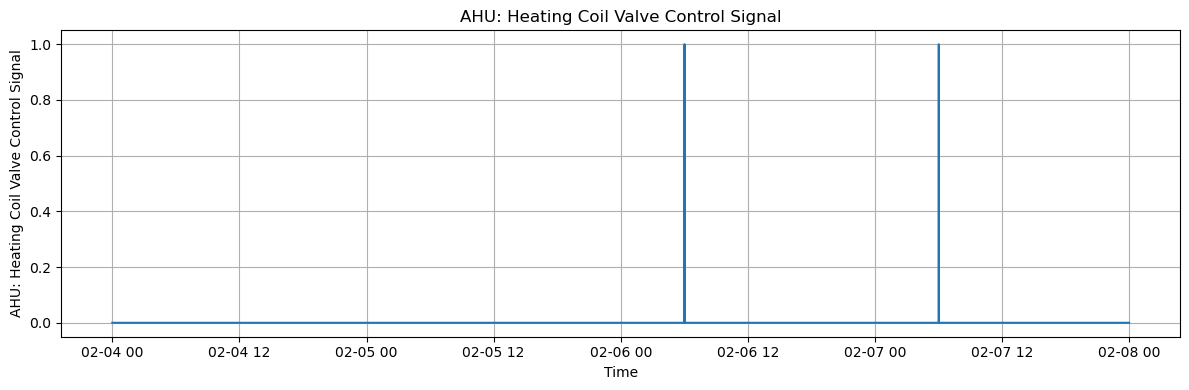

In [77]:
import matplotlib.pyplot as plt

# D√©finir l'axe x = temps
time = df_filtered['Datetime']

# Liste de colonnes √† tracer: Le d√©faut de ce jour(6 et 7 f√©vrier 2017consiste √† falsifier la valeur du capteur de temp√©rature ext√©rieure, donc jai 
# choisi les variables les plus pertinentes pour l'analyse de ce d√©faut
variables = [
    'AHU: Outdoor Air Temperature',
    'AHU: Supply Air Temperature',
    'AHU: Mixed Air Temperature',
    'AHU: Cooling Coil Valve Control Signal',
    'AHU: Heating Coil Valve Control Signal'
]

# Tracer chaque variable
for var in variables:
    plt.figure(figsize=(12, 4))
    plt.plot(time, df_filtered[var])
    plt.title(var)
    plt.xlabel('Time')
    plt.ylabel(var)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [78]:
# 1. Nettoyage : supprimer les espaces en fin de nom
df_filtered.columns = df_filtered.columns.str.strip()

# 2. S√©lection des colonnes utiles
selected_columns = [
    'Datetime',
    'AHU: Outdoor Air Temperature',
    'AHU: Supply Air Temperature',
    'AHU: Mixed Air Temperature',
    'AHU: Cooling Coil Valve Control Signal',
    'AHU: Heating Coil Valve Control Signal'
]

df_filtered = df_filtered[selected_columns].copy()

In [79]:
def determine_fault(date):
    if date in [pd.to_datetime("2017-02-04").date(), pd.to_datetime("2017-02-05").date()]:
        return 0  # normal
    else:
        return 1  # d√©faut sur 6 

df_filtered['z_t'] = df_filtered['Datetime'].dt.date.apply(determine_fault)


In [80]:
from sklearn.preprocessing import StandardScaler

# 4.1 Extraction des colonnes features (capteurs)
feature_columns = [
    'AHU: Outdoor Air Temperature',
    'AHU: Supply Air Temperature',
    'AHU: Mixed Air Temperature',
    'AHU: Cooling Coil Valve Control Signal',
    'AHU: Heating Coil Valve Control Signal'
]

X = df_filtered[feature_columns].values

# Standardisation (centrer-r√©duire)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4.2 Extraction de la cible
y = df_filtered['z_t'].values


In [81]:
import pymc as pm
import numpy as np

# V√©rifie la forme
n_obs, n_features = X_scaled.shape

with pm.Model() as logistic_model:
    # Priors : # w et b sont les param√®tres du mod√®le logistique
    w = pm.Normal("w", mu=0, sigma=5, shape=n_features) # w cest un Vecteur de poids
    b = pm.Normal("b", mu=0, sigma=5) # b est un scalaire (biais) 
    # w et b sont les param√®tres du mod√®le logistique

    # Calcul de la proba : œÄ_t = sigmoid(w¬∑x_t + b)
    # o√π x_t est le vecteur de caract√©ristiques √† l'instant t (les observations)
    eta = pm.math.dot(X_scaled, w) + b # eta est lscore brut avant la transformation
    pi = pm.Deterministic("pi", pm.math.sigmoid(eta))  # pi est la probabilit√© de defaut √† l'instant t

    # Likelihood 
    z = pm.Bernoulli("z", p=pi, observed=y) # z est la variable binaire observ√©e (0 ou 1)

    # √âchantillonnage MCMC
    trace = pm.sample(1000, tune=1000, target_accept=0.9, random_seed=50)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 233 seconds.


In [82]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# Extraire les √©chantillons post√©rieurs de pi
pi_samples = trace.posterior["pi"].stack(samples=("chain", "draw")).values 

# Moyenne et intervalle de cr√©dibilit√© (95%) pour chaque minute
pi_mean = pi_samples.mean(axis=1) 
pi_hpd = az.hdi(pi_samples.T, hdi_prob=0.95)  # shape: (n_obs, 2)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16020\3774978155.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pi_hpd = az.hdi(pi_samples.T, hdi_prob=0.95)  # shape: (n_obs, 2)


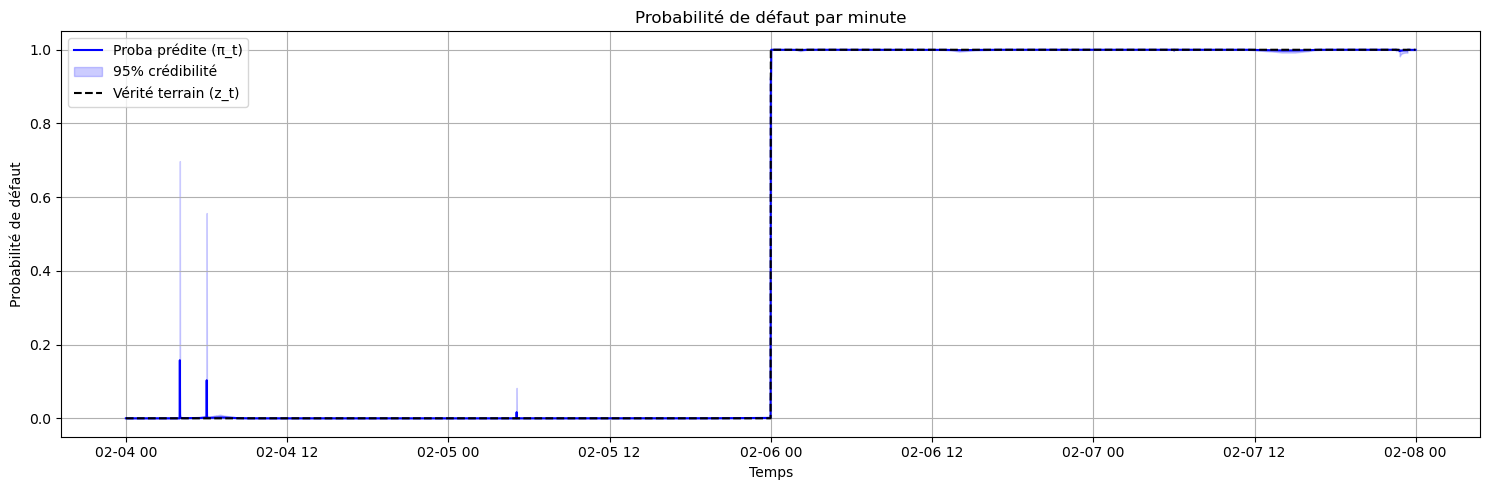

In [83]:
time = df_filtered["Datetime"]
z_true = y  # z_t r√©els

plt.figure(figsize=(15, 5))
plt.plot(time, pi_mean, label="Proba pr√©dite (œÄ_t)", color='blue')
plt.fill_between(time, pi_hpd[:, 0], pi_hpd[:, 1], color='blue', alpha=0.2, label="95% cr√©dibilit√©")
plt.plot(time, z_true, label="V√©rit√© terrain (z_t)", color='black', linestyle='--')
plt.title("Probabilit√© de d√©faut par minute")
plt.xlabel("Temps")
plt.ylabel("Probabilit√© de d√©faut")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [84]:
# Extraire les poids
w_samples = trace.posterior["w"].stack(samples=("chain", "draw")).values

# Moyenne et intervalle de cr√©dibilit√©
w_mean = w_samples.mean(axis=1)
w_hpd = az.hdi(w_samples.T, hdi_prob=0.95)

# Noms des capteurs utilis√©s (dans l‚Äôordre)
features = [
    'AHU: Outdoor Air Temperature',
    'AHU: Supply Air Temperature',
    'AHU: Mixed Air Temperature',
    'AHU: Cooling Coil Valve Control Signal',
    'AHU: Heating Coil Valve Control Signal'
]

# Affichage texte
for i, name in enumerate(features):
    print(f"{name:<40}  w_mean = {w_mean[i]: .3f}, 95% CI = [{w_hpd[i,0]:.3f}, {w_hpd[i,1]:.3f}]")


AHU: Outdoor Air Temperature              w_mean = -17.084, 95% CI = [-21.651, -12.689]
AHU: Supply Air Temperature               w_mean =  2.344, 95% CI = [0.733, 4.122]
AHU: Mixed Air Temperature                w_mean = -1.142, 95% CI = [-3.391, 1.280]
AHU: Cooling Coil Valve Control Signal    w_mean =  0.773, 95% CI = [-3.107, 5.778]
AHU: Heating Coil Valve Control Signal    w_mean =  3.650, 95% CI = [-0.580, 10.025]


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16020\2820968289.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  w_hpd = az.hdi(w_samples.T, hdi_prob=0.95)


In [85]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Pr√©diction binaire : zÃÇ_t = 1 si œÄ_t ‚â• 0.5
z_pred = (pi_mean >= 0.5).astype(int)

# Comparaison avec les vraies valeurs z_t
print("Taux de bonne classification :", accuracy_score(y, z_pred))


Taux de bonne classification : 1.0


In [86]:
# Calcul des m√©triques standard
precision = precision_score(y, z_pred)
recall = recall_score(y, z_pred)
f1 = f1_score(y, z_pred)
cm = confusion_matrix(y, z_pred)

print(f"Pr√©cision : {precision:.3f}")
print(f"Rappel    : {recall:.3f}")
print(f"F1-score  : {f1:.3f}")
print("Matrice de confusion :")
print(cm)


Pr√©cision : 1.000
Rappel    : 1.000
F1-score  : 1.000
Matrice de confusion :
[[2880    0]
 [   0 2880]]


In [87]:
import pandas as pd

# Charger le fichier complet si pas d√©j√† en m√©moire
df_all = pd.read_csv(file_path)  # file_path = chemin complet de ton fichier MZVAV-1.csv
df_all.columns = df_all.columns.str.strip()  # Nettoyage des noms de colonnes
df_all['Datetime'] = pd.to_datetime(df_all['Datetime'])

# Filtrer les 3 jours cibles
start_date = pd.to_datetime("2017-11-01")
end_date = pd.to_datetime("2017-11-15 23:59:59")
df_nov = df_all[(df_all['Datetime'] >= start_date) & (df_all['Datetime'] <= end_date)].copy()
df_nov.reset_index(drop=True, inplace=True)

# S√©lectionner les m√™mes colonnes capteurs qu‚Äôavant
feature_columns = [
    'AHU: Outdoor Air Temperature',
    'AHU: Supply Air Temperature',
    'AHU: Mixed Air Temperature',
    'AHU: Cooling Coil Valve Control Signal',
    'AHU: Heating Coil Valve Control Signal'
]

# Extraire X_t
X_nov = df_nov[feature_columns].values

# Standardiser avec le **m√™me scaler que pr√©c√©demment entra√Æn√©**
X_nov_scaled = scaler.transform(X_nov)  # ATTENTION : ne pas refaire fit_transform, juste transform

# Extraire la v√©rit√© terrain (z_t) mais ne pas l‚Äôutiliser maintenant
z_nov = df_nov['Fault Detection Ground Truth'].values

# Sauvegarder le temps pour l'affichage
time_nov = df_nov['Datetime']


In [88]:
import numpy as np

# Extraire les valeurs post√©rieures moyennes de w et b depuis le trace existant
# (mod√®le entra√Æn√© sur 5‚Äì6 f√©vrier)
w_post_mean = trace.posterior["w"].stack(samples=("chain", "draw")).mean(axis=1).values
b_post_mean = trace.posterior["b"].stack(samples=("chain", "draw")).mean().values

# Calcul de Œ∑_t = w·µÄ¬∑x_t + b
eta_nov = np.dot(X_nov_scaled, w_post_mean) + b_post_mean

# Calcul de œÄ_t = sigmoid(Œ∑_t)
pi_nov = 1 / (1 + np.exp(-eta_nov))


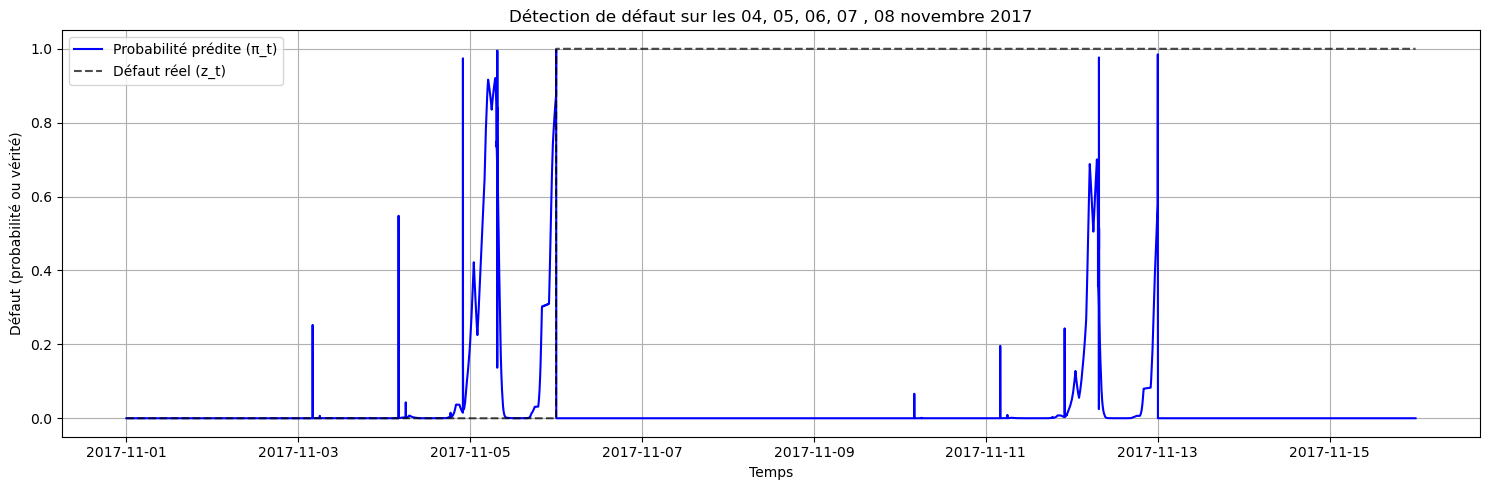

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Courbe bleue : probabilit√© pr√©dite par le mod√®le
plt.plot(time_nov, pi_nov, label="Probabilit√© pr√©dite (œÄ_t)", color="blue")

# Courbe noire pointill√©e : v√©rit√© terrain binaire (z_t)
plt.plot(time_nov, z_nov, label="D√©faut r√©el (z_t)", linestyle="--", color="black", alpha=0.7)

plt.title("D√©tection de d√©faut sur les 04, 05, 06, 07 , 08 novembre 2017")
plt.xlabel("Temps")
plt.ylabel("D√©faut (probabilit√© ou v√©rit√©)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [90]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Appliquer un seuil pour convertir les probabilit√©s œÄ_t en pr√©diction binaire
z_pred_nov = (pi_nov >= 0.5).astype(int)
# Comparaison avec la v√©rit√© z_nov
acc = accuracy_score(z_nov, z_pred_nov)
prec = precision_score(z_nov, z_pred_nov)
rec = recall_score(z_nov, z_pred_nov)
f1 = f1_score(z_nov, z_pred_nov)

# Affichage
print("üìä √âvaluation sur 10‚Äì12 novembre 2017")
print(f"Accuracy   : {acc:.3f}")
print(f"Pr√©cision  : {prec:.3f}")
print(f"Rappel     : {rec:.3f}")
print(f"F1-score   : {f1:.3f}")


üìä √âvaluation sur 10‚Äì12 novembre 2017
Accuracy   : 0.325
Pr√©cision  : 0.338
Rappel     : 0.013
F1-score   : 0.025
